In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

In [4]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

In [8]:
!pip install combo

  Created wheel for combo: filename=combo-0.1.2-py3-none-any.whl size=42026 sha256=727d1f3b88b04e59257d65be67ff9d324bd66099351dca9e912d3cc0726eb373
  Stored in directory: c:\users\yeonj\appdata\local\pip\cache\wheels\40\d4\93\ea2224f96bd2868538da3b8231211c42632221600b080ddf16
Successfully built combo


In [9]:
import pandas as pd
import numpy as np

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [13]:
import os

In [17]:
os.listdir(os.getcwd() + '/dat')

['train_v9rqX0R.csv', 'test_AbJTz2l.csv', 'sample_submission_8RXa3c6.csv']

In [20]:
# reading the big mart sales training data
df = pd.read_csv(os.getcwd() + "/dat/train_v9rqX0R.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


In [22]:
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)


In [23]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,
                                                       check_estimator=False,
                                                       random_state=random_state),
    'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),
                                     contamination=outliers_fraction,
                                     check_estimator=False,
                                     random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [27]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i, clf_name, clf )

0 Angle-based Outlier Detector (ABOD) ABOD(contamination=0.05, method='fast', n_neighbors=5)
1 Cluster-based Local Outlier Factor (CBLOF) CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None,
   random_state=RandomState(MT19937) at 0x2162549CE40, use_weights=False)
2 Feature Bagging FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, novelty=True, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.05,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=RandomState(MT19937) at 0x2162549CE40, verbose=0)
3 Histogram-base Outlier Detection (HBOS) HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)
4 Isolation Forest IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


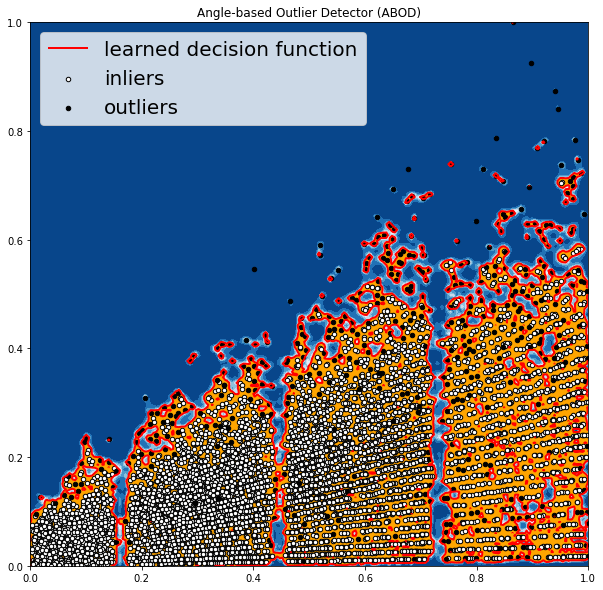

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


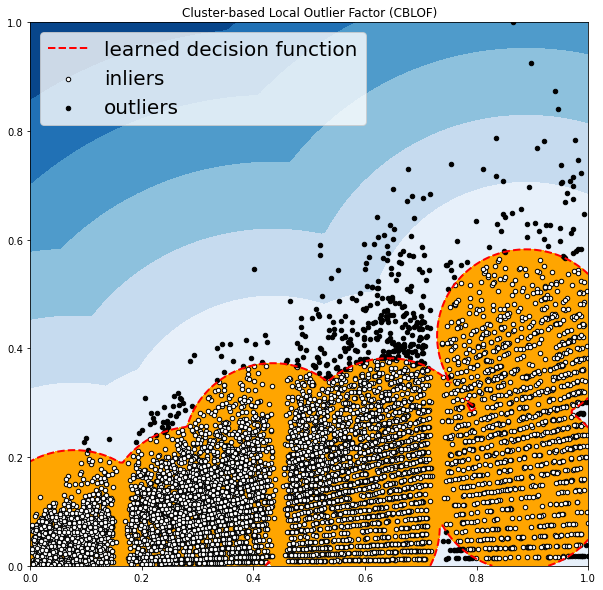

OUTLIERS :  381 INLIERS :  8142 Feature Bagging


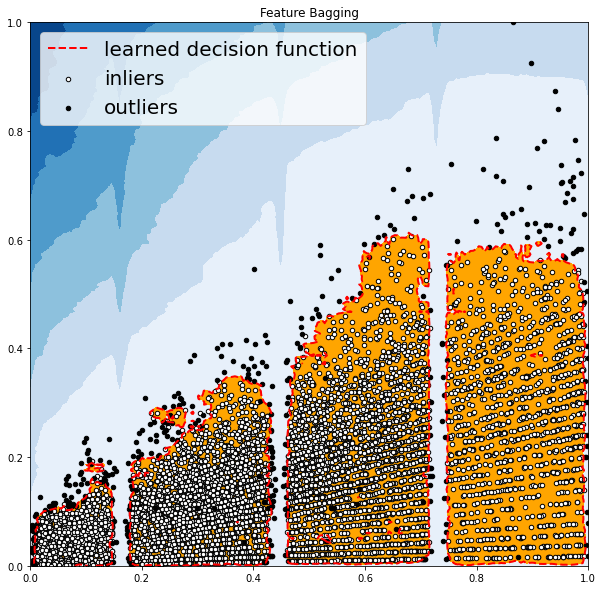

OUTLIERS :  418 INLIERS :  8105 Histogram-base Outlier Detection (HBOS)


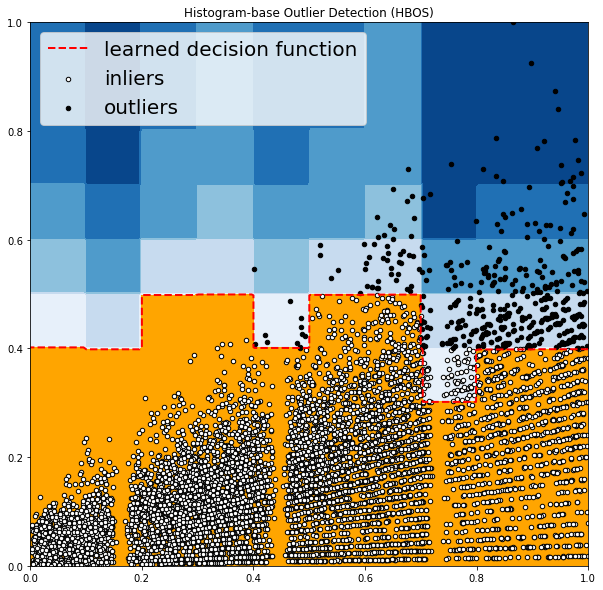

OUTLIERS :  426 INLIERS :  8097 Isolation Forest


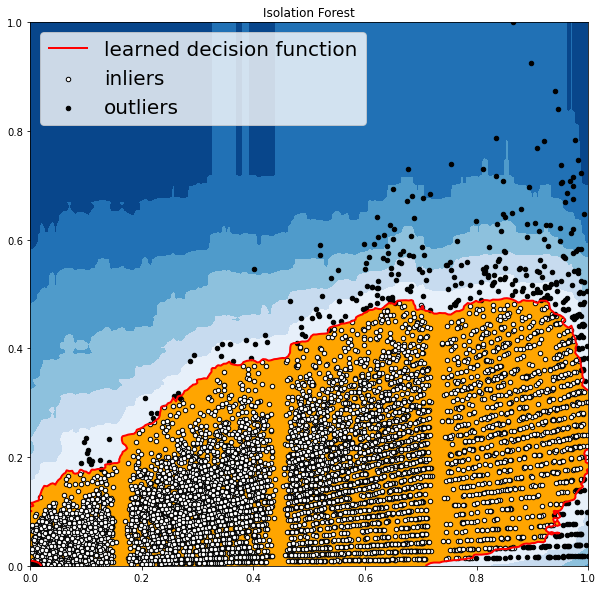

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


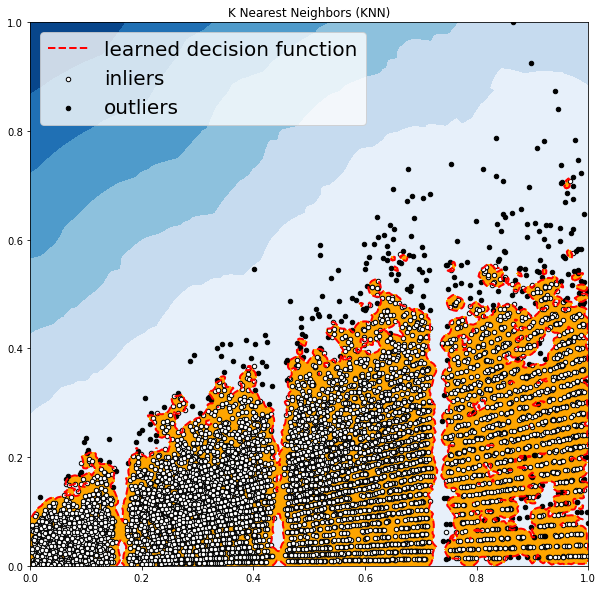

OUTLIERS :  176 INLIERS :  8347 Average KNN


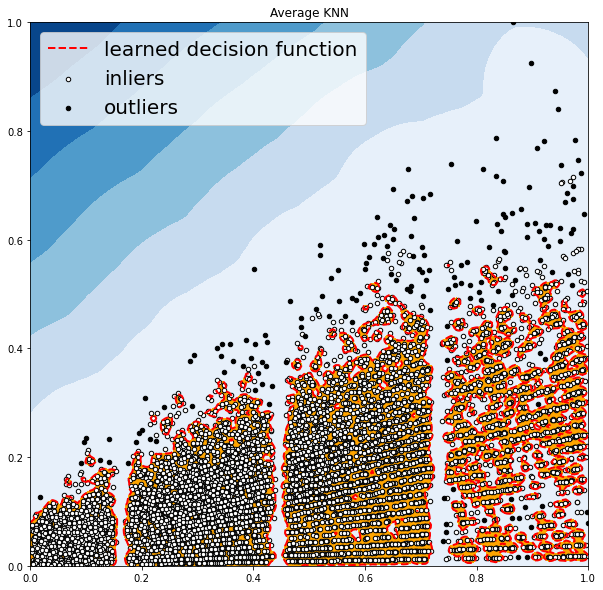

In [26]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    fnPlot(df, n_outliers, n_inliers, clf_name, clf)

In [25]:
def fnPlot(df, n_outliers, n_inliers, clf_name, clf):
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z,
                 levels=np.linspace(Z.min(), threshold, 7),
                 cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z,
                    levels=[threshold],linewidths=2,
                    colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                 colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/